## Fine-tune Llama 3 for Financial Data Sentiment Analysis

Sentiment analysis on financial and economic information is highly relevant for businesses for several key reasons, ranging from market insights (gain valuable insights into market trends, investor confidence, and consumer behavior) to risk management (identifying potential reputational risks) to investment decisions (gauging the sentiment of stakeholders, investors, and the general public businesses can assess the potential success of various investment opportunities).

Before the technicalities of fine-tuning a large language model like Llama 3, we have to find the correct dataset to demonstrate the potentialities of fine-tuning.

Particularly within the realm of finance and economic texts, annotated datasets are notably rare, with many being exclusively reserved for proprietary purposes. To address the issue of insufficient training data, scholars from the Aalto University School
of Business introduced in 2014 a set of approximately 5000 sentences. This collection aimed to establish human-annotated benchmarks, serving as a standard for evaluating alternative modeling techniques. The involved annotators (16 people with
adequate background knowledge on financial markets) were instructed to assess the sentences solely from the perspective of an investor, evaluating whether the news potentially holds a positive, negative, or neutral impact on the stock price.

The FinancialPhraseBank dataset is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive. This structured dataset serves as a valuable resource for analyzing and understanding the complex dynamics of sentiment in the domain of financial news. It has been used in various studies and research initiatives, since its inception in the work by Malo, P., Sinha, A., Korhonen, P., Wallenius, J., and Takala, P.  "Good debt or bad debt: Detecting semantic orientations in economic texts.", published in the Journal of the Association for Information Science and Technology in 2014.

As a first step, we install the specific libraries necessary to make this example work.

* accelerate is a distributed training library for PyTorch by HuggingFace. It allows you to train your models on multiple GPUs or CPUs in parallel (distributed configurations), which can significantly speed up training in presence of multiple GPUs (we won't use it in our example).
* peft is a Python library by HuggingFace for efficient adaptation of pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model's parameters. PEFT methods only fine-tune a small number of (extra) model parameters, thereby greatly decreasing the computational and storage costs.
* bitsandbytes by Tim Dettmers, is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions. It allows to run models stored in 4-bit precision: while 4-bit bitsandbytes stores weights in 4-bits, the computation still happens in 16 or 32-bit and here any combination can be chosen (float16, bfloat16, float32, and so on).
* transformers is a Python library for natural language processing (NLP). It provides a number of pre-trained models for NLP tasks such as text classification, question answering, and machine translation.
* trl is a full stack library by HuggingFace providing a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step.

## Installations and imports

In [1]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers=="4.40.0"
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft
!pip install -q -U tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


The code imports the os module and sets two environment variables:
* CUDA_VISIBLE_DEVICES: This environment variable tells PyTorch which GPUs to use. In this case, the code is setting the environment variable to 0, which means that PyTorch will use the first GPU.
* TOKENIZERS_PARALLELISM: This environment variable tells the Hugging Face Transformers library whether to parallelize the tokenization process. In this case, the code is setting the environment variable to false, which means that the tokenization process will not be parallelized.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

The code import warnings; warnings.filterwarnings("ignore") imports the warnings module and sets the warning filter to ignore. This means that all warnings will be suppressed and will not be displayed. Actually during training there are many warnings that do not prevent the fine-tuning but can be distracting and make you wonder if you are doing the correct things.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In the following cell there are all the other imports for running the notebook

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

2024-05-12 11:07:54.623598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:07:54.623695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:07:54.745724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.1.2


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


Disabling two features in PyTorch related to memory efficiency and speed during operations on the Graphics Processing Unit (GPU) specifically for the scaled dot product attention (SDPA) function.

In [7]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

## Preparing the data and the core evaluation functions

The code in the next cell performs the following steps:

1. Reads the input dataset from the all-data.csv file, which is a comma-separated value (CSV) file with two columns: sentiment and text.
2. Splits the dataset into training and test sets, with 300 samples in each set. The split is stratified by sentiment, so that each set contains a representative sample of positive, neutral, and negative sentiments.
3. Shuffles the train data in a replicable order (random_state=10)
4. Transforms the texts contained in the train and test data into prompts to be used by Llama: the train prompts contains the expected answer we want to fine-tune the model with
5. The residual examples not in train or test, for reporting purposes during training (but it won't be used for early stopping), is treated as evaluation data, which is sampled with repetition in order to have a 50/50/50 sample (negative instances are very few, hence they should be repeated)
5. The train and eval data are wrapped by the class from Hugging Face (https://huggingface.co/docs/datasets/index)

This prepares in a single cell train_data, eval_data and test_data datasets to be used in our fine tuning.

In [8]:
filename = "../input/sentiment-analysis-for-financial-news/all-data.csv"

df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

In [9]:
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [10]:
df.shape

(4846, 2)

In [11]:
df.columns

Index(['sentiment', 'text'], dtype='object')

In [12]:
df.duplicated().sum()

6

In [13]:
df = df.drop_duplicates()

In [14]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4840 non-null   object
 1   text       4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [16]:
df.nunique()

sentiment       3
text         4838
dtype: int64

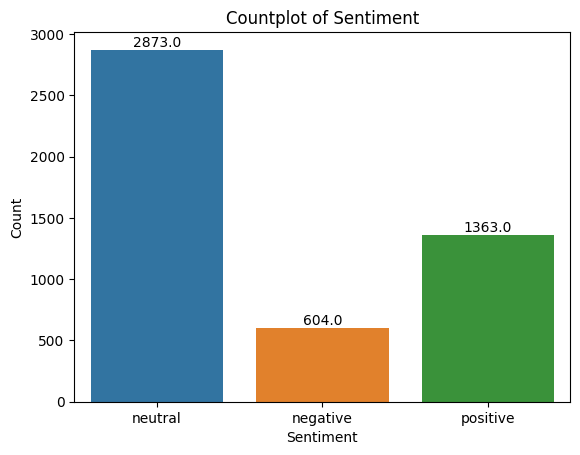

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ax = sns.countplot(x='sentiment', data=df)

plt.title('Countplot of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

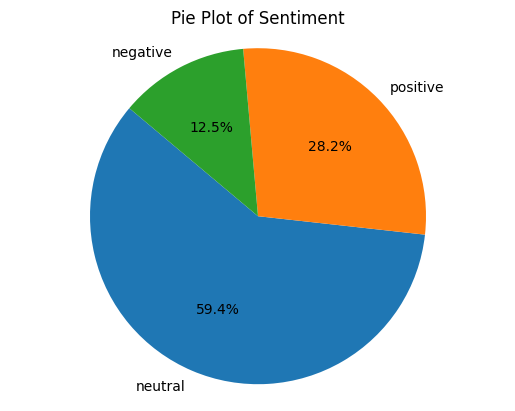

In [18]:
sentiment_counts = df['sentiment'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Pie Plot of Sentiment')

plt.axis('equal')

plt.show()

In [19]:
X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=400,
                                    test_size=200, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

This code seems to be splitting a DataFrame (`df`) into training, testing, and evaluation datasets based on the 'sentiment' column. Here's what each part of the code does:

1. **Splitting Data into Train, Test, and Evaluation Sets**:
   - It initializes empty lists `X_train` and `X_test` to store training and testing subsets for each sentiment category.
   - It iterates over each sentiment category ('positive', 'neutral', 'negative') and performs the following:
     - Splits the data into a train and test set using `train_test_split()` function from scikit-learn.
     - Each train and test set contains 300 samples per sentiment category (`train_size=300` and `test_size=300`).
     - Random state is fixed to ensure reproducibility (`random_state=42`).
     - Appends the train and test sets to the corresponding lists.
   - Concatenates the train and test sets across all sentiment categories.
   - Prepares an evaluation set (`X_eval`) by sampling 50 examples per sentiment category without replacement from the remaining data (data not used in training and testing sets).
   - Finally, it resets the index of the training set to ensure a continuous index.

2. **Purpose**:
   - This code is commonly used in machine learning workflows to split a dataset into training, testing, and evaluation sets. 
   - The training set is used to train the model, the testing set is used to evaluate the model's performance during development, and the evaluation set is kept separate for final evaluation after model tuning.
   - By sampling data from each sentiment category separately, it ensures a balanced representation of sentiments in both the training and testing sets.

3. **Output**:
   - `X_train`: Concatenated training set with balanced representation across sentiment categories.
   - `X_test`: Concatenated testing set with balanced representation across sentiment categories.
   - `X_eval`: Evaluation set with 50 samples per sentiment category for final evaluation.

In [20]:
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

These functions generate prompts for sentiment analysis tasks based on the provided data points. Here's what each function does:

1. **generate_prompt(data_point)**:
   - This function generates a prompt for sentiment analysis based on a given data point.
   - It takes a `data_point` dictionary as input, which presumably contains a "text" key representing the news headline and a "sentiment" key representing the sentiment label ("positive", "neutral", or "negative").
   - The function constructs a prompt string using an f-string.
   - The prompt asks to analyze the sentiment of the news headline enclosed in square brackets and return the corresponding sentiment label as "positive", "neutral", or "negative".
   - It embeds the news headline and its sentiment label from the `data_point` dictionary into the prompt string.
   - The `.strip()` method removes any leading or trailing whitespace from the generated prompt string.

2. **generate_test_prompt(data_point)**:
   - This function generates a prompt for testing sentiment analysis models based on a given data point.
   - Similar to `generate_prompt()`, it takes a `data_point` dictionary as input, which presumably contains a "text" key representing the news headline.
   - The function constructs a prompt string using an f-string.
   - The prompt asks to analyze the sentiment of the news headline enclosed in square brackets and leave the sentiment label blank for testing.
   - It embeds the news headline from the `data_point` dictionary into the prompt string.
   - The `.strip()` method removes any leading or trailing whitespace from the generated prompt string.

These functions are useful for generating prompts to be used with natural language processing models, particularly for sentiment analysis tasks. The generated prompts provide clear instructions for analyzing the sentiment of news headlines and are suitable for training or testing sentiment analysis models.

In [21]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

This code prepares the training, evaluation, and testing datasets by generating prompts for sentiment analysis tasks and organizing the data into formats suitable for Hugging Face's datasets library. Here's what each part of the code does:

1. **Generating Prompts**:
   - `X_train.apply(generate_prompt, axis=1)`: Applies the `generate_prompt` function to each row in the training set (`X_train`) along the rows axis.
   - `X_eval.apply(generate_prompt, axis=1)`: Applies the `generate_prompt` function to each row in the evaluation set (`X_eval`) along the rows axis.
   - `X_test.apply(generate_test_prompt, axis=1)`: Applies the `generate_test_prompt` function to each row in the testing set (`X_test`) along the rows axis.
   - The result is a pandas DataFrame with a single column named "text" containing the generated prompts.

2. **Creating DataFrames**:
   - `pd.DataFrame(...)`: Constructs pandas DataFrames from the generated prompts for the training, evaluation, and testing sets.
   - The columns are named "text" to match the format expected by Hugging Face's datasets library.

3. **Preparing Labels**:
   - `y_true = X_test.sentiment`: Extracts the true sentiment labels from the testing set (`X_test`) to be used for evaluation later.

4. **Creating Datasets**:
   - `Dataset.from_pandas(...)`: Converts the pandas DataFrames (`X_train` and `X_eval`) into datasets compatible with Hugging Face's datasets library.
   - These datasets are used for training (`train_data`) and evaluation (`eval_data`) of sentiment analysis models.

This code sets up the data in a format suitable for training and evaluating sentiment analysis models using Hugging Face's datasets library. The generated prompts provide clear instructions for analyzing the sentiment of news headlines, and the datasets are organized for easy integration into machine learning pipelines.

Next we create a function to evaluate the results from our fine-tuned sentiment model. The function performs the following steps:

1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [22]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

This `evaluate` function evaluates the performance of a sentiment analysis model by comparing the true sentiment labels (`y_true`) with the predicted sentiment labels (`y_pred`). Here's what each part of the function does:

1. **Label Mapping**:
   - It defines a mapping dictionary (`mapping`) that maps sentiment labels to numerical values (`'positive': 2`, `'neutral': 1`, `'negative': 0`). This mapping allows for easier evaluation and calculation of accuracy.

2. **Map Function**:
   - It defines a `map_func` function that maps sentiment labels to their corresponding numerical values using the mapping dictionary.

3. **Mapping Sentiment Labels**:
   - It applies the `map_func` function to both `y_true` and `y_pred` arrays using `np.vectorize`. This converts sentiment labels to numerical values for easier comparison and evaluation.

4. **Accuracy Calculation**:
   - It calculates the overall accuracy score using `accuracy_score` from scikit-learn.

5. **Accuracy per Label**:
   - It calculates accuracy scores for each sentiment label separately and prints them. This provides insights into how well the model performs for each sentiment category individually.

6. **Classification Report**:
   - It generates a classification report using `classification_report` from scikit-learn, which includes precision, recall, F1-score, and support for each sentiment category.

7. **Confusion Matrix**:
   - It generates a confusion matrix using `confusion_matrix` from scikit-learn, which provides a summary of predicted versus true sentiment labels.

Overall, this function provides comprehensive evaluation metrics for assessing the performance of a sentiment analysis model, including overall accuracy, accuracy per label, a classification report, and a confusion matrix. These metrics help in understanding the strengths and weaknesses of the model and guide further improvements.

## Testing the model without fine-tuning

Next we need to take care of the model, which is a 8b-chat-hf (8 billion parameters, no RLHF, in the HuggingFace compatible format), loading from Kaggle models and quantization.

Model loading and quantization:

* First the code loads the Llama-3 language model from the Kaggle Models.
* Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
* Next, it creates a BitsAndBytesConfig object with the following settings:
    1. load_in_4bit: Load the model weights in 4-bit format.
    2. bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
    3. bnb_4bit_compute_dtype: Use the float16 data type for computations.
    4. bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
* Then the code creates a AutoModelForCausalLM object from the pre-trained Llama-2 language model, using the BitsAndBytesConfig object for quantization.
* After that, the code disables caching for the model.
* Finally the code sets the pre-training token probability to 1.

Tokenizer loading:

* First, the code loads the tokenizer for the Llama-3 language model.
* Then it sets the padding token to be the end-of-sequence (EOS) token.
* Finally, the code sets the padding side to be "right", which means that the input sequences will be padded on the right side. This is crucial for correct padding direction (this is the way with Llama 2).

In [23]:
model_name = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 2048
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


This code snippet loads a pre-trained language model for causal language modeling using the Hugging Face Transformers library. Here's a breakdown of what each part of the code does:

1. **Model Loading**:
   - `model_name = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"`: Specifies the path or identifier of the pre-trained language model to be loaded.
   - `AutoModelForCausalLM.from_pretrained(...)`: Loads a pre-trained model for causal language modeling using the specified `model_name`. This function automatically detects the model architecture based on the provided `model_name`.
   - `device_map=device`: Specifies the device on which the model should be loaded (e.g., 'cuda:0' for GPU or 'cpu' for CPU).
   - `torch_dtype=compute_dtype`: Specifies the data type to be used for computations within the model (e.g., 'float16').
   - `quantization_config=bnb_config`: Specifies the quantization configuration for the model, which includes options for quantizing weights and activations.

2. **BitsAndBytes Configuration**:
   - `BitsAndBytesConfig`: Configures options for the BitsAndBytes library, which is used for quantization and optimization.
   - `load_in_4bit=True`: Specifies whether to load weights in 4-bit precision.
   - `bnb_4bit_use_double_quant=False`: Specifies whether to use double quantization.
   - `bnb_4bit_quant_type="nf4"`: Specifies the quantization type (e.g., "nf4").
   - `bnb_4bit_compute_dtype=compute_dtype`: Specifies the data type for computations during quantization.
   - This configuration aims to optimize memory and computation efficiency by quantizing model weights and activations while minimizing the impact on model performance.

3. **Tokenizer Initialization**:
   - `max_seq_length = 2048`: Specifies the maximum sequence length for tokenization.
   - `AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)`: Initializes a tokenizer for the pre-trained model specified by `model_name`, with the maximum sequence length set to `max_seq_length`.
   - `tokenizer.pad_token_id = tokenizer.eos_token_id`: Specifies the pad token ID to be equal to the end-of-sequence (EOS) token ID. This configuration likely sets the padding token to the end-of-sequence token, which is common in causal language modeling tasks.

Overall, this code snippet loads a pre-trained language model for causal language modeling, configures it for quantization using the BitsAndBytes library, and initializes a tokenizer for tokenizing input sequences.


In the next cell, we set a function for predicting the sentiment of a news headline using the Llama-3 language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted.
model: The pre-trained Llama-3 language model.
tokenizer: The tokenizer for the Llama-3 language model.

The function works as follows:

1. For each news headline in the test DataFrame:
    * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
    * Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.
    * Extract the predicted sentiment label from the generated text.
    * Append the predicted sentiment label to the y_pred list.
2. Return the y_pred list.

The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Llama-2 language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [24]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens = 1, 
                        temperature = 0.0,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

This `predict` function generates predictions for sentiment analysis using a pre-trained language model. Here's a breakdown of what each part of the function does:

1. **Prediction Loop**:
   - The function iterates through each test sample (`X_test`) using `tqdm` for progress tracking.
   - For each test sample, it retrieves the corresponding prompt from the `X_test` DataFrame.

2. **Hugging Face Pipeline**:
   - It initializes a Hugging Face pipeline for text generation using the specified model and tokenizer.
   - The task is set to "text-generation", indicating that the pipeline will generate text based on the provided prompt.
   - Additional parameters such as `max_new_tokens` and `temperature` control the generation process.

3. **Generating Text**:
   - It generates text based on the provided prompt using the pipeline.
   - The generated text is split using '=' as a delimiter, and the sentiment label part is extracted.
   - Based on the extracted sentiment label, it determines the predicted sentiment ('positive', 'negative', 'neutral', or 'none').

4. **Appending Predictions**:
   - It appends the predicted sentiment label to the `y_pred` list for each test sample.

5. **Returning Predictions**:
   - After iterating through all test samples, it returns the list of predicted sentiment labels (`y_pred`).

Overall, this function uses a pre-trained language model for text generation to predict the sentiment of each test sample. The sentiment labels are extracted from the generated text, and the predictions are returned as a list of sentiment labels.

At this point, we are ready to test the Llama 3 8b-chat-hf model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [25]:
y_pred = predict(test, model, tokenizer)

100%|██████████| 600/600 [03:38<00:00,  2.74it/s]


In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the 8b-chat-hf model tends to just predict a neutral sentiment and seldom it detects positive or negative sentiment.

In [26]:
evaluate(y_true, y_pred)

Accuracy: 0.327
Accuracy for label 0: 0.000
Accuracy for label 1: 0.965
Accuracy for label 2: 0.015

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.33      0.96      0.49       200
           2       0.30      0.01      0.03       200

    accuracy                           0.33       600
   macro avg       0.21      0.33      0.17       600
weighted avg       0.21      0.33      0.17       600


Confusion Matrix:
[[  0 200   0]
 [  0 193   7]
 [  0 197   3]]


## Fine-tuning

In the next cell we set everything ready for the fine-tuning. We configures and initializes a Simple Fine-tuning Trainer (SFTTrainer) for training a large language model using the Parameter-Efficient Fine-Tuning (PEFT) method, which should save time as it operates on a reduced number of parameters compared to the model's overall size. The PEFT method focuses on refining a limited set of (additional) model parameters, while keeping the majority of the pre-trained LLM parameters fixed. This significantly reduces both computational and storage expenses. Additionally, this strategy addresses the challenge of catastrophic forgetting, which often occurs during the complete fine-tuning of LLMs.

PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.

TrainingArguments:

The training_arguments object specifies the parameters for training the model. The following are some of the most important parameters:

* output_dir: The directory where the training logs and checkpoints will be saved.
* num_train_epochs: The number of epochs to train the model for.
* per_device_train_batch_size: The number of samples in each batch on each device.
* gradient_accumulation_steps: The number of batches to accumulate gradients before updating the model parameters.
* optim: The optimizer to use for training the model.
* save_steps: The number of steps after which to save a checkpoint.
* logging_steps: The number of steps after which to log the training metrics.
* learning_rate: The learning rate for the optimizer.
* weight_decay: The weight decay parameter for the optimizer.
* fp16: Whether to use 16-bit floating-point precision.
* bf16: Whether to use BFloat16 precision.
* max_grad_norm: The maximum gradient norm.
* max_steps: The maximum number of steps to train the model for.
* warmup_ratio: The proportion of the training steps to use for warming up the learning rate.
* group_by_length: Whether to group the training samples by length.
* lr_scheduler_type: The type of learning rate scheduler to use.
* report_to: The tools to report the training metrics to.
* evaluation_strategy: The strategy for evaluating the model during training.

SFTTrainer:

The SFTTrainer is a custom trainer class from the TRL library. It is used to train large language models (also using the PEFT method).

The SFTTrainer object is initialized with the following arguments:

* model: The model to be trained.
* train_dataset: The training dataset.
* eval_dataset: The evaluation dataset.
* peft_config: The PEFT configuration.
* dataset_text_field: The name of the text field in the dataset.
* tokenizer: The tokenizer to use.
* args: The training arguments.
* packing: Whether to pack the training samples.
* max_seq_length: The maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model by calling the train() method

In [27]:
output_dir="trained_weigths"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=4,            # number of steps before performing a backward/update pass
    gradient_checkpointing=False,             # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=10,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

This code snippet sets up the training process for a language model using the QLoRA method with the PEFT library by Hugging Face. Let's break down each part:

1. **Output Directory and Training Arguments**:
   - `output_dir`: Specifies the directory where trained weights and logs will be saved.
   - `TrainingArguments`: Configures various training parameters such as the number of epochs, batch size, optimizer settings, learning rate, and logging options.

2. **PEFT Configuration**:
   - `LoraConfig`: Configures the QLoRA method with specific hyperparameters such as `lora_alpha`, `lora_dropout`, `r` (number of attention heads), `bias`, and `task_type`.

3. **Trainer Initialization**:
   - `SFTTrainer`: Initializes the trainer for training with PEFT.
   - `model`: Specifies the pre-trained language model to be trained.
   - `args`: Specifies the training arguments defined earlier.
   - `train_dataset` and `eval_dataset`: Specifies the training and evaluation datasets.
   - `peft_config`: Specifies the PEFT configuration.
   - `dataset_text_field`: Specifies the name of the field in the dataset containing the text data.
   - `tokenizer`: Specifies the tokenizer used for tokenizing input sequences.
   - `max_seq_length`: Specifies the maximum sequence length.
   - `packing`: Specifies whether to pack the inputs into fixed-length sequences.
   - `dataset_kwargs`: Additional keyword arguments for dataset preparation.

Overall, this code sets up a trainer for training a language model using the QLoRA method with PEFT, configures the training process, and specifies the model, datasets, tokenizer, and other necessary components for training.

The following code will train the model using the trainer.train() method and then save the trained model to the trained-model directory. Using The standard GPU P100 offered by Kaggle, the training should be quite fast.

In [28]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.831800,0.770644


TrainOutput(global_step=300, training_loss=0.9596682500839233, metrics={'train_runtime': 1138.3069, 'train_samples_per_second': 1.054, 'train_steps_per_second': 0.264, 'total_flos': 4628109347487744.0, 'train_loss': 0.9596682500839233, 'epoch': 1.0})

The model and the tokenizer are saved to disk for later usage.

In [29]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.json')

Afterwards, loading the TensorBoard extension and start TensorBoard, pointing to the logs/runs directory, which is assumed to contain the training logs and checkpoints for your model, will allow you to understand how the models fits during the training.

In [30]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

## Testing

The following code will first predict the sentiment labels for the test set using the predict() function. Then, it will evaluate the model's performance on the test set using the evaluate() function. The result now should be impressive with an overall accuracy of over 0.8 and high accuracy, precision and recall for the single sentiment labels. The prediction of the neutral label can still be improved, yet it is impressive how much could be done with little data and some fine-tuning.

In [31]:
y_pred = predict(test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 600/600 [04:03<00:00,  2.46it/s]

Accuracy: 0.873
Accuracy for label 0: 0.955
Accuracy for label 1: 0.845
Accuracy for label 2: 0.820

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       200
           1       0.81      0.84      0.83       200
           2       0.87      0.82      0.84       200

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600


Confusion Matrix:
[[191   7   2]
 [  8 169  23]
 [  4  32 164]]


The following code will create a Pandas DataFrame called evaluation containing the text, true labels, and predicted labels from the test set. This is expectially useful for understanding the errors that the fine-tuned model makes, and gettting insights on how to improve the prompt.

In [32]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

The evaluation results are indeed good when compared to simpler benchmarks such as a CONV1D + bidirectional LSTM based model () such as: https://www.kaggle.com/code/lucamassaron/lstm-baseline-for-sentiment-analysis

With this testing, the fine-tuning of Llama 3 has reached its conclusion. Dont't forget to upvote if you find the notebook useful for your projects or work! 